In [1]:
import pandas as pd
import os

def load_calisp_data(filename):
    # (1) load data
    if os.path.isdir(filename):
        file_data = []
        for f in os.listdir(filename):
            f = os.path.join(filename, f)
            file_data.append(pd.read_feather(f))
        data = pd.concat(file_data)
    else:
        data = pd.read_feather(filename)
    # (2) calculate deltas
    data["delta_na"] = (data["ratio_na"] / (0.011056585166521 / 0.988943414833479)-1)*1000
    data["delta_fft"] = (data["ratio_fft"] / (0.011056585166521 / 0.988943414833479)-1)*1000
    print (f'Loaded {len(data.index)} spectra from file(s)')
    return data

def filter_calisp_data(data, target):
    if target.lower() == 'na':
        subdata = data.loc[lambda df: (df['flag_peak_at_minus_one_pos'] == False) &
                            (df['flag_spectrum_is_wobbly'] == False) &
                            (df['flag_psm_has_low_confidence'] == False) &
                            (df['flag_psm_is_ambiguous'] == False) &
                            (df['flag_spectrum_is_contaminated'] == False) &
                            (df['flag_peptide_assigned_to_multiple_bins'] == False), :]
    elif target.lower() == 'fft':
        subdata = data.loc[lambda df: (df['error_fft'] < 0.001) &
                           (df['flag_peptide_assigned_to_multiple_bins'] == False), :]
    elif target.lower() == 'clumpy':
        subdata = data.loc[lambda df: (df['error_clumpy'] < 0.001) &
                           (df['flag_peptide_assigned_to_multiple_bins'] == False), :]
        
    print (f'{len(subdata.index)} ({len(subdata.index)/len(data.index)*100:.1f}%) remaining after filters.')
    
    return subdata

def estimate_clumpiness(data):
    subdata = data.loc[lambda df: df["error_clumpy"] < 0.001,:]
    clumpiness = []
    for c in ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']:
        try:
            count, division = np.histogram(subdata[c], bins=50)
            count = count[1:-1]
            opt = 0.02* np.where(count == count.max())[0][0]/0.96
            clumpiness.append(opt)
        except ValueError:
            pass
    return clumpiness / sum(clumpiness)

In [2]:

def benchmark_sip_saturation(data):
    background_13C = 0.011056585166521
    background_12C = 1 - background_13C
    
    filenames = data["ms_run"].unique()
    benchmarking = pd.DataFrame(columns=['file', '% label', 'ratio', '#spectra', 'NA median', 'NA mean', 'N median', 'N mean'])
    for f in filenames:
        words = f.split('_')
        nominal_value = float(words[3].replace("-", "."))
        unlabeled_fraction = 1 - nominal_value/100
        C12 = unlabeled_fraction * background_12C
        C13 = nominal_value/100 + unlabeled_fraction * background_13C
        ratio = C13/C12 * 100
        subdata = data.loc[lambda df: df['ms_run'] == f, :]
        benchmarking.loc[len(benchmarking)] = [f, nominal_value, ratio, len(subdata.index), 
                                               subdata['ratio_na'].median(), subdata["ratio_na"].mean(), 
                                               subdata["psm_neutrons"].median(), subdata["psm_neutrons"].mean()]
        #print(f, nominal_value, ratio)
    benchmarking = benchmarking.sort_values("ratio")
    benchmarking = benchmarking.reset_index(drop=True)
    return benchmarking

def benchmark_sip_mixes_of_labeled_and_unlabeled_cells(data):
    background_13C = 0.011056585166521
    background_12C = 1 - background_13C
    
    filenames = data["ms_run"].unique()
    benchmarking = pd.DataFrame(columns=['file', 'label type', '% label', '% cells labeled', 
                                         'ratio', '#spectra', 'NA median', 'NA 75%', 'N mean'])
    for f in filenames:
        words = f.split('_')
        percent_label = int(words[3])
        try:
            percent_cells_labeled = 100 - int(words[4][1:])
            if "C213C" in words[5]:
                label_type = 'full'
            else:
                label_type = 'C2'
        except ValueError:
            label_type = '-'
            percent_cells_labeled = 0
        labeled_fraction = percent_label/100 * percent_cells_labeled/100
        C12 = (1-labeled_fraction) * background_12C
        C13 = (1-labeled_fraction) * background_13C + labeled_fraction
        ratio = C13/C12 * 100
        subdata = data.loc[lambda df: df['ms_run'] == f, :]
        benchmarking.loc[len(benchmarking)] = [f, label_type, percent_label, percent_cells_labeled, 
                                               ratio, len(subdata.index), subdata['ratio_na'].median(),
                                               subdata['ratio_na'].quantile(0.75),
                                               subdata["psm_neutrons"].mean()]
    benchmarking = benchmarking.sort_values(['label type', '% label', '% cells labeled'])
    benchmarking = benchmarking.reset_index(drop=True)
    return benchmarking
        
def benchmark_sip_mock_community_data(data):
    background_13C = 0.011056585166521
    background_12C = 1 - background_13C

    # For false positive discovery rates we set the threshold at the 13C/12C associated with 1/4 of a generation
    # of labeling. The E. coli values (1.7, 4.2 and 7.1) are for 1 generation at 1, 5 and 10% label, 
    # and we take the background (1.07) into account as well. 
    thresholds = {1:  1.07 + (1.7-1.07)/4,  
                  5:  1.07 + (4.2-1.07)/4, 
                  10: 1.07 + (7.1-1.07)/4}
    
    
    filenames = data["ms_run"].unique()
    bin_names = data["bins"].unique()
    benchmarking = pd.DataFrame(columns=['file', 'bin', '% label', 'ratio', 
                                         '#spectra', 'mean intensity', 'NA median', 'N mean', 'False Positive'])
    false_positives = 0
    for b in bin_names:
        bindata = data.loc[lambda df: df['bins'] == b, :]        
        for f in filenames:
            words = f.split('_')
            nominal_value = 0
            if len(words)>4:
                nominal_value = int(words[3])
            unlabeled_fraction = 1 - nominal_value/100
            C12 = unlabeled_fraction * background_12C
            C13 = nominal_value/100 + unlabeled_fraction * background_13C
            ratio = C13/C12 * 100
            binfiledata = bindata.loc[lambda df: df['ms_run'] == f, :]
            is_false_positive = 0
            try:
                if b != "K12" and binfiledata['ratio_na'].median() > thresholds[nominal_value]:
                    is_false_positive = 1
                    false_positives += 1
            except KeyError:
                pass
            benchmarking.loc[len(benchmarking)] = [f, b, nominal_value, ratio, len(binfiledata.index), 
                                                   binfiledata['spectrum_total_intensity'].mean(),
                                                   binfiledata['ratio_na'].median(),
                                                   binfiledata["psm_neutrons"].mean(), is_false_positive]
            
    benchmarking = benchmarking.sort_values(['bin', '% label'])
    benchmarking = benchmarking.reset_index(drop=True)
    return benchmarking
        


In [3]:
# Here we load the data for E. coli labeled to saturation with 13C2 (single 13C per molecule) glucose
# The table shows that the median is a better estimator than the mean for neutron-abundance (NA) method.
# However, for the # of neutrons detected in MS2 spectra (N), the mean is the better estimator
# The sensitivity of Calisp can be read from the table. Assimilation of 0.1% 13C is measurably different
# from the background in all experiments (compare rows 10-12 with rows 0-3)

data = load_calisp_data("/home/kinestetika/Proteomics/SIP/Ecoli_singlecarbon/calisp/")
data = filter_calisp_data(data, 'na')
data["ratio_na"] = data["ratio_na"]*100
data["psm_neutrons"] = data["psm_neutrons"]*100

benchmarks00 = benchmark_sip_saturation(data)
benchmarks00.style

Loaded 3942126 spectra from file(s)
2693289 (68.3%) remaining after filters.


,file,% label,ratio,#spectra,NA median,NA mean,N median,N mean
0,Run1_Ecol_R1_0_C213C_400ng,0.000000,1.118020,127481,1.060391,1.274701,0.000000,0.099362
1,Run1_Ecol_R2_0_C213C_400ng,0.000000,1.118020,97860,1.053493,1.200216,0.000000,0.111147
2,Run1_Ecol_R3_0_C213C_400ng,0.000000,1.118020,129476,1.056320,1.198287,0.000000,0.097346
3,Run1_Ecol_R1_0_C213C_400ng_181221172407,0.000000,1.118020,110014,1.060411,1.223374,0.000000,0.116848
4,Run1_Ecol_R3_0-01_C213C_400ng,0.010000,1.128133,134884,1.065398,1.218357,0.000000,0.107700
5,Run1_Ecol_R2_0-01_C213C_400ng,0.010000,1.128133,112468,1.059086,1.183467,0.000000,0.111375
6,Run1_Ecol_R1_0-01_C213C_400ng,0.010000,1.128133,126853,1.067009,1.262645,0.000000,0.098427
7,Run1_Ecol_R2_0-025_C213C_400ng,0.025000,1.143306,129534,1.076142,1.219332,0.000000,0.117270
8,Run1_Ecol_R1_0-025_C213C_400ng,0.025000,1.143306,139782,1.076888,1.266837,0.000000,0.115713
9,Run1_Ecol_R3_0-025_C213C_400ng,0.025000,1.143306,119636,1.085892,1.307345,0.000000,0.095692


In [4]:
# Here we load the data for E. coli labeled to saturation with fully labeled (13C1-6) glucose
# The table shows that the median is a better estimator than the mean for neutron-abundance (NA) method.
# However, for the # of neutrons detected in MS2 spectra (N), the mean is the better estimator
# The sensitivity of Calisp can be read from the table. Assimilation of 0.1% 13C is measurably different
# from the background in all experiments (compare rows 10-12 with rows 0-3)

data = load_calisp_data("/home/kinestetika/Proteomics/SIP/Ecoli_fulllabel_Aug18/calisp/")
data = filter_calisp_data(data, 'na')
data["ratio_na"] = data["ratio_na"]*100
data["psm_neutrons"] = data["psm_neutrons"]*100

benchmarks01 = benchmark_sip_saturation(data)
benchmarks01.style

Loaded 4397537 spectra from file(s)
2902325 (66.0%) remaining after filters.


,file,% label,ratio,#spectra,NA median,NA mean,N median,N mean
0,Run2_Ecoli268_R2a_0_13C_800ng,0.000000,1.118020,107861,1.050633,1.178388,0.000000,0.050414
1,Run1_Ecoli268_R1a_0_13C_400ng,0.000000,1.118020,131608,1.042869,1.143125,0.000000,0.067197
2,Run2_Ecoli268_R3a_0_13C_800ng,0.000000,1.118020,124302,1.050652,1.154827,0.000000,0.060701
3,Run1_Ecoli268_R2a_0_13C_400ng_control,0.000000,1.118020,91656,1.053151,1.189893,0.000000,0.053355
4,Run1_Ecoli268_R1a_0-01_13C_400ng,0.010000,1.128133,140002,1.047704,1.140956,0.000000,0.059465
5,Run1_Ecoli268_R3a_0-01_13C_400ng,0.010000,1.128133,111306,1.059480,1.179691,0.000000,0.064341
6,Run2_Ecoli268_R2a_0-01_13C_800ng,0.010000,1.128133,126938,1.053172,1.151411,0.000000,0.050829
7,Run1_Ecoli268_R1a_0-025_13C_400ng,0.025000,1.143306,131415,1.057999,1.154479,0.000000,0.059781
8,Run1_Ecoli268_R2a_0-025_13C_400ng,0.025000,1.143306,109050,1.061538,1.159827,0.000000,0.058162
9,Run1_Ecoli268_R3a_0-025_13C_400ng,0.025000,1.143306,114497,1.064985,1.169668,0.000000,0.073507


In [5]:
# Here we load the data for B. subtilis labeled to saturation with 13C2 (single 13C per molecule) glucose
# The table shows that the median is a better estimator than the mean for neutron-abundance (NA) method.
# However, for the # of neutrons detected in MS2 spectra (N), the mean is the better estimator
# The sensitivity of Calisp can be read from the table. Assimilation of 0.1% 13C is measurably different
# from the background in all experiments (compare rows 10-12 with rows 0-3)

data = load_calisp_data("/home/kinestetika/Proteomics/SIP/Bsub_singlecarbon/calisp/")
data = filter_calisp_data(data, 'na')
data["ratio_na"] = data["ratio_na"]*100
data["psm_neutrons"] = data["psm_neutrons"]*100

benchmarks10 = benchmark_sip_saturation(data)
benchmarks10.style

Loaded 2869280 spectra from file(s)
1937513 (67.5%) remaining after filters.


,file,% label,ratio,#spectra,NA median,NA mean,N median,N mean
0,Run1_Bsub_R2_0_C213C_800ng,0.000000,1.118020,87934,1.090136,1.242674,0.000000,0.148772
1,Run1_Bsub_R3_0_C213C_800ng,0.000000,1.118020,100007,1.064622,1.187427,0.000000,0.143543
2,Run1_Bsub_R1_0_C213C_800ng,0.000000,1.118020,79058,1.048649,1.123220,0.000000,0.110995
3,Run1_Bsub_R1_0_C213C_800ng_181215155533,0.000000,1.118020,103247,1.068808,1.201499,0.000000,0.130820
4,Run1_Bsub_R2_0-01_C213C_800ng,0.010000,1.128133,71979,1.095264,1.190124,0.000000,0.185842
5,Run1_Bsub_R3_0-01_C213C_800ng,0.010000,1.128133,64217,1.094906,1.212304,0.000000,0.172480
6,Run1_Bsub_R1_0-01_C213C_800ng,0.010000,1.128133,96837,1.075026,1.166289,0.000000,0.155549
7,Run1_Bsub_R1_0-025_C213C_800ng,0.025000,1.143306,115653,1.077508,1.161253,0.000000,0.128058
8,Run1_Bsub_R3_0-025_C213C_800ng,0.025000,1.143306,86935,1.087485,1.184108,0.000000,0.130713
9,Run1_Bsub_R2_0-025_C213C_800ng,0.025000,1.143306,90128,1.091663,1.180400,0.000000,0.142440


In [6]:
# Here we load the data for B. subtilis labeled to saturation with fully labeled (13C1-6) glucose
# The table shows that the median is a better estimator than the mean for neutron-abundance (NA) method.
# However, for the # of neutrons detected in MS2 spectra (N), the mean is the better estimator
# The sensitivity of Calisp can be read from the table. Assimilation of 0.1% 13C is measurably different
# from the background in all experiments (compare rows 10-12 with rows 0-3)


data = load_calisp_data("/home/kinestetika/Proteomics/SIP/Bsub_fulllabel_May18/calisp/")
data = filter_calisp_data(data, 'na')
data["ratio_na"] = data["ratio_na"]*100
data["psm_neutrons"] = data["psm_neutrons"]*100

benchmarks11 = benchmark_sip_saturation(data)
benchmarks11.style

Loaded 2216230 spectra from file(s)
1420688 (64.1%) remaining after filters.


,file,% label,ratio,#spectra,NA median,NA mean,N median,N mean
0,Run1_Bsub_R3_0_13C_400ng,0.000000,1.118020,58074,1.121152,1.363217,0.000000,0.137136
1,Run1_Bsub_R2_0_13C_400ng,0.000000,1.118020,60583,1.091647,1.233271,0.000000,0.133244
2,Run1_Bsub_R1_0_13C_400ng_2,0.000000,1.118020,14769,1.129741,1.397487,0.000000,0.083499
3,Run1_Bsub_R1_0_13C_400ng,0.000000,1.118020,42093,1.075720,1.244014,0.000000,0.112181
4,Run1_Bsub_R2_0-01_13C_400ng,0.010000,1.128133,63195,1.101687,1.176419,0.000000,0.134305
5,Run2_Bsub_R3_0-01_13C_800ng,0.010000,1.128133,56930,1.092719,1.226528,0.000000,0.090244
6,Run1_Bsub_R1_0-01_13C_400ng,0.010000,1.128133,61603,1.078536,1.135246,0.000000,0.124326
7,Run1_Bsub_R2_0-025_13C_400ng,0.025000,1.143306,98415,1.090805,1.207280,0.000000,0.145005
8,Run2_Bsub_R1_0-025_13C_800ng,0.025000,1.143306,5564,1.060663,1.313862,0.000000,0.223830
9,Run1_Bsub_R3_0-025_13C_400ng,0.025000,1.143306,72747,1.099988,1.202520,0.000000,0.154470


recovery, intercept, r2
0.946, -0.014, 1.000
0.704, 0.252, 1.000
0.854, 0.102, 0.998
0.696, 0.290, 0.998


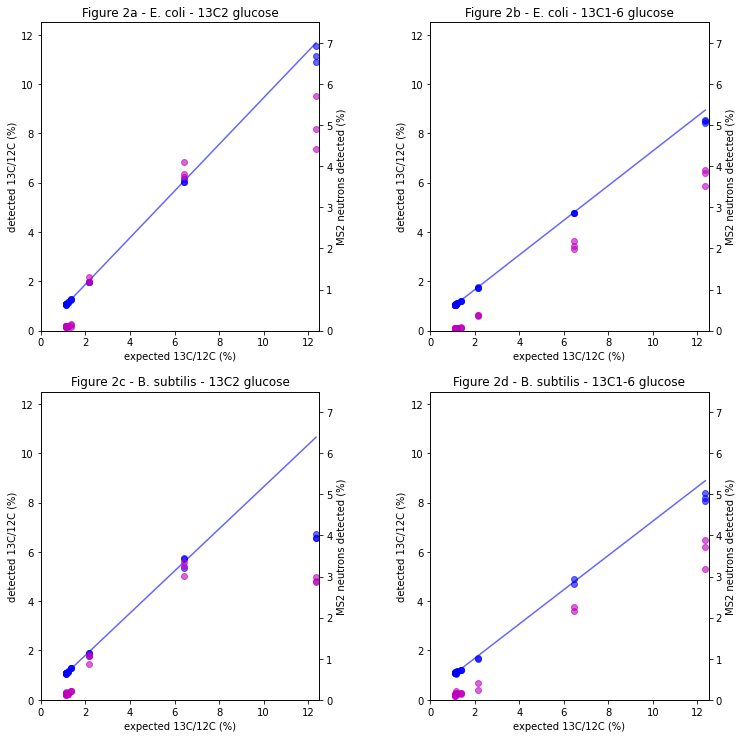

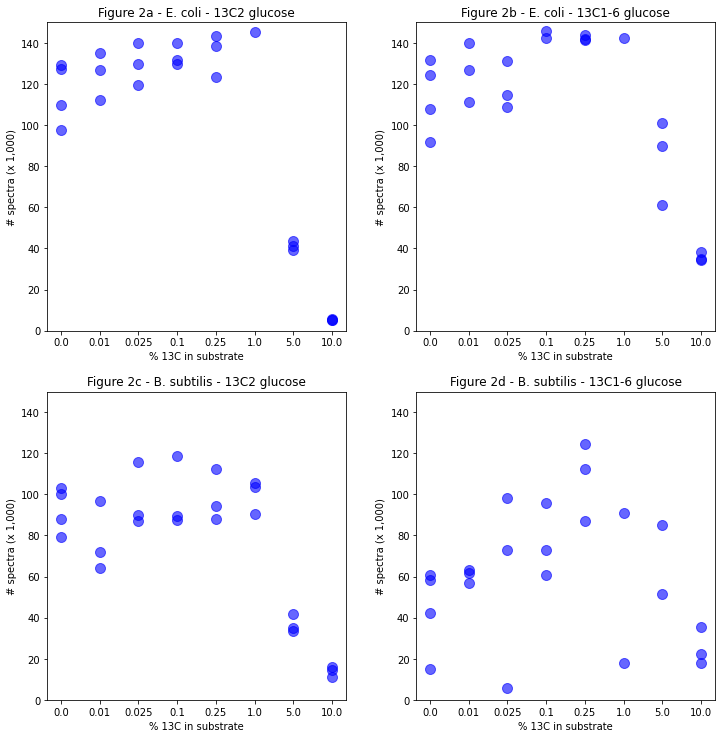

In [7]:
# Figure 2 shows the data of the above four tables (E. coli and B. subtilis, labeled to saturation with 13C2 
# and 13C1-6 glucose).
# First we plot the measured versus the expected amount of 13C and perform linear regression on the relationship.
# Then, we plot the # of spectra detected for each experiment.
# Note that the measured 13C/12C saturated above 5% label applied, leading to a nonlinear relationship. This
# is also associated with a much-declined # of spectra for experiments with high amounts of label applied.
# The loss of linearity and loss of spectra can be explained by a decreased intensity and, eventually, 
# complete loss of the mono-isotopic peak for heavily labeled spectra. Calisp does not detect spectra if the 
# mono-isotopic peak is absent.

%matplotlib inline
import matplotlib.pyplot as plot
from scipy import stats
from functools import partial

def line_funct(slope, intercept, x):
    return intercept + slope * x

try:
    benchmarks11 = benchmarks11.drop([17, 21])
except KeyError:
    pass

fig1, f1_axes = plot.subplots(2, 2, figsize=(10,10))
fig1.tight_layout(h_pad=4, w_pad=8)

fig1_inset, f1_inset_axes = plot.subplots(2, 2, figsize=(10,10))
fig1_inset.tight_layout(h_pad=4, w_pad=4)


instr = [[0,0, "Figure 2a - E. coli - 13C2 glucose", benchmarks00, 12.5],
         [0,1, "Figure 2b - E. coli - 13C1-6 glucose", benchmarks01, 12.5],
         [1,0, "Figure 2c - B. subtilis - 13C2 glucose", benchmarks10, 12.5],
         [1,1, "Figure 2d - B. subtilis - 13C1-6 glucose", benchmarks11, 12.5]]

print(f'recovery, intercept, r2')
for i in instr:
    benchmarks = i[3]
    yax001 = f1_axes[i[0]][i[1]]
    yax001.set_title(i[2])
    yax001.set_xlabel('expected 13C/12C (%)')
    yax001.set_ylabel('detected 13C/12C (%)')
    yax001.set_ylim([0,i[4]])
    yax001.set_xlim([0,i[4]])
    x_values_0 = benchmarks["ratio"].values
    y_values_0 = benchmarks["NA median"].values
    yax001.scatter(x_values_0, y_values_0, c='b', alpha=0.6)
    
    sub_benchmarks = benchmarks.loc[lambda df: df['ratio'] < 10, :]
    slope, intercept, r_value, p_value, std_error = stats.linregress(
        sub_benchmarks["ratio"], sub_benchmarks["NA median"])
    print(f'{slope:.3f}, {intercept:.3f}, {r_value**2:.3f}')
    lf = partial(line_funct, slope, intercept)
    yax001.plot(benchmarks["ratio"], lf(benchmarks["ratio"]),  c='b', alpha=0.6)

    yax002 = f1_axes[i[0]][i[1]].twinx()
    yax002.set_ylabel('MS2 neutrons detected (%)')
    yax002.set_ylim([0,7.5])
    x_values_0 = benchmarks["ratio"].values
    y_values_0 = benchmarks["N mean"].values
    yax002.scatter(x_values_0, y_values_0, c='m', alpha=0.6)

    yax_inset = f1_inset_axes[i[0]][i[1]]
    yax_inset.set_title(i[2])
    yax_inset.set_ylim([0,150])
    yax_inset.set_xlabel('% 13C in substrate')
    yax_inset.set_ylabel('# spectra (x 1,000)')
    x_values_0 = benchmarks["% label"].values.astype(str) 
    y_values_0 = benchmarks["#spectra"].values
    yax_inset.scatter(x_values_0, y_values_0/1000, c='b', alpha=0.6, s=100)
    

In [8]:
# Evaluation of the clumpy carbon model - it works as expected. Note that to get these results, you need to:
# (1) need to label until saturation (five or more generations)
# (2) run calisp.py with argument "--compute_clumps"
# And also note that calisp will take longer to complete 

data = load_calisp_data("/home/kinestetika/Proteomics/SIP/clumpy_carbon_test/calisp/")
data = filter_calisp_data(data, 'na')

Loaded 643673 spectra from file(s)
436906 (67.9%) remaining after filters.


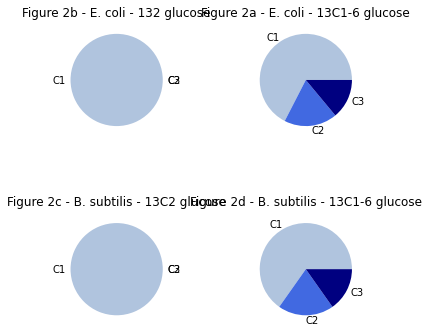

In [9]:
import numpy as np

titles = {"Run1_Ecoli268_R2a_1_13C_400ng": "Figure 2a - E. coli - 13C1-6 glucose",
         "Run1_Ecol_R2_1_C213C_400ng": "Figure 2b - E. coli - 132 glucose",
         "Run1_Bsub_R2_1_C213C_800ng": "Figure 2c - B. subtilis - 13C2 glucose",
         "Run2_Bsub_R2_1_13C_800ng": "Figure 2d - B. subtilis - 13C1-6 glucose"}

fig1, f1_axes = plot.subplots(2, 2, figsize=(5,5))
fig1.tight_layout(h_pad=4, w_pad=4)

axes = [f1_axes[0][1], f1_axes[0][0], f1_axes[1][0], f1_axes[1][1]]

filenames = data["ms_run"].unique()
for i in [1, 0, 2, 3]:
    f = filenames[i]
    subdata = data.loc[lambda df: df["ms_run"] == f, :]
    clumpiness = estimate_clumpiness(subdata)

    yax001 = axes[i]
    yax001.set_title(titles[f])
    yax001.pie(clumpiness, labels=['C1', 'C2', 'C3'], colors=['lightsteelblue', 'royalblue', 'navy'])
    

In [10]:
# Here we explore the performance of the approach with mixes of labeled and unlabeled E. coli cells. This
# is what SIP results would normally look like, as we would normally not label to saturation, but would monitor
# the assimilation during the experiment, starting from unlabeled cells and gradually building up more label.
# The column ""% label" shows the amount of label applied in the experiment. The column "% cells labeled" is a 
# measure for the progression of the experiment, the # of generations of labeling. 50% corresponds to a single
# generation of labeling, 1% to 1/100 of a generation, 5% 1/16 of a generation and 10% 1/8 of a generation.  

data = load_calisp_data("/home/kinestetika/Proteomics/SIP/Ecoli_labeled_unlabeled/calisp/")
data = filter_calisp_data(data, 'na')
data["ratio_na"] = data["ratio_na"]*100
data["psm_neutrons"] = data["psm_neutrons"]*100

benchmarks = benchmark_sip_mixes_of_labeled_and_unlabeled_cells(data)
pd.set_option('precision', 3)
benchmarks.style

Loaded 4562762 spectra from file(s)
3022728 (66.2%) remaining after filters.


,file,label type,% label,% cells labeled,ratio,#spectra,NA median,NA 75%,N mean
0,Run1_Ecol_R3_0_C213C_400ng,-,0,0,1.118,129476,1.056,1.187,0.097
1,Run1_Ecol_R1_0_C213C_400ng_181221172407,-,0,0,1.118,110014,1.060,1.200,0.117
2,Run1_Ecol_R2_0_C213C_400ng,-,0,0,1.118,97860,1.053,1.180,0.111
3,Run1_Ecol_R1_0_C213C_400ng,-,0,0,1.118,127481,1.060,1.216,0.099
4,Run1_Ecol_R1b_1_U99_FL1_400ng,C2,1,1,1.128,168186,1.062,1.202,0.126
5,Run1_Ecol_R1b_1_U95_FL5_400ng,C2,1,5,1.169,117480,1.078,1.223,0.146
6,Run2_Ecol_R1b_1_U90_FL10_400ng,C2,1,10,1.219,178636,1.124,1.264,0.137
7,Run1_Ecol_R1b_1_U50_FL50_400ng,C2,1,50,1.626,167324,1.433,1.636,0.207
8,Run2_Ecol_R1b_10_U99_FL1_400ng,C2,10,1,1.219,165551,1.070,1.222,0.135
9,Run2_Ecol_R1b_10_U95_FL5_400ng,C2,10,5,1.626,171046,1.109,1.307,0.142


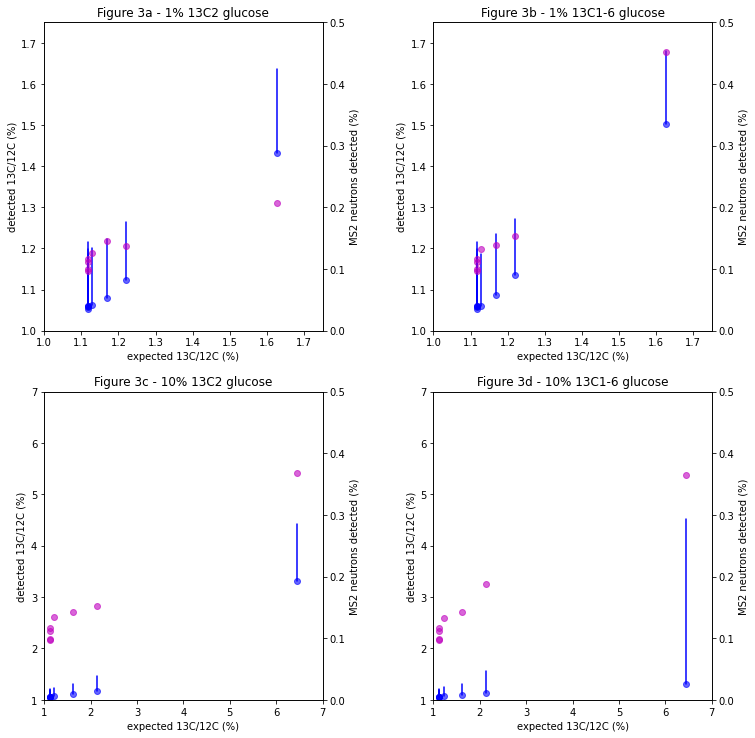

In [11]:
# Figure 3 shows the results shown in the table above. We plot the median 13C/12C measured as blue circles. The
# blue lines extending upward from the circles show the range between the median and the upper quartile. The
# purple circles show the % of neutrons detected in the associated MS2 spectra.
# The data show excellent, linear detection of label for those experiments where 1% of the glucose was labeled.
# Whith 10% of the glucose labeled, recovery was much lower and the distribution of the data was much broader, 
# as can be seen from much larger spread between the median and the upper quartile of the data.
#
# With regard to sensitivity, when the glucose was 10% labeled, the method was able to detect labeling at 
# even at only 1/100 generation of labeling. when the glucose was only 1% labeled, 1/16 of a generation was
# needed to unambiguously detect uptake.
# MS2 detection of neutrons was more quantitative when fully labeled glucose was used and with application of 
# 10% label.

from matplotlib import collections as matcoll

fig1, f1_axes = plot.subplots(2, 2, figsize=(10,10))
fig1.tight_layout(h_pad=4, w_pad=8)

instr = [[0,0, "Figure 3a - 1% 13C2 glucose", [0,1,2,3,4,5,6,7], 1.75],
         [0,1, "Figure 3b - 1% 13C1-6 glucose", [0,1,2,3,12,13,14,15], 1.75],
         [1,0, "Figure 3c - 10% 13C2 glucose", [0,1,2,3,8,9,10,11], 7],
         [1,1, "Figure 3d - 10% 13C1-6 glucose", [0,1,2,3,16,17,18,19], 7]]

for i in instr:
    yax001 = f1_axes[i[0]][i[1]]
    yax001.set_title(i[2])
    yax001.set_xlabel('expected 13C/12C (%)')
    yax001.set_ylabel('detected 13C/12C (%)')
    yax001.set_ylim([1,i[4]])
    yax001.set_xlim([1,i[4]])
    x_values_0 = benchmarks.iloc[i[3]]["ratio"].values
    y_values_0 = benchmarks.iloc[i[3]]["NA median"].values
    y_values_1 = benchmarks.iloc[i[3]]["NA 75%"].values
    lines = []
    for f in i[3]:
        pair = [(benchmarks.at[f, "ratio"], benchmarks.at[f, "NA median"]), 
                (benchmarks.at[f, "ratio"], benchmarks.at[f, "NA 75%"])]
        lines.append(pair)        
    
    linecoll = matcoll.LineCollection(lines, colors='b', capstyle='round')
    yax001.add_collection(linecoll)
    yax001.scatter(x_values_0, y_values_0, c='b', alpha=0.6)
                 
    yax002 = f1_axes[i[0]][i[1]].twinx()
    yax002.set_ylabel('MS2 neutrons detected (%)')
    yax002.set_ylim([0,0.5])
    x_values_0 = benchmarks.iloc[i[3]]["ratio"].values
    y_values_0 = benchmarks.iloc[i[3]]["N mean"].values
    yax002.scatter(x_values_0, y_values_0, c='m', alpha=0.6)


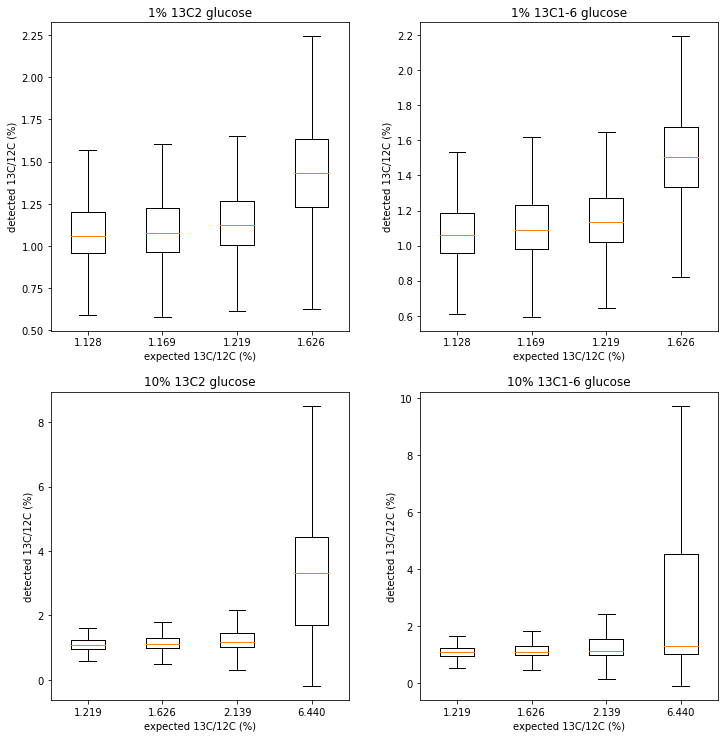

In [12]:
# Boxplots showing the same data

fig1, f1_axes = plot.subplots(2, 2, figsize=(10,10))
fig1.tight_layout(h_pad=4, w_pad=4)

instr = [[0,0, "1% 13C2 glucose", [4,5,6,7], 1.7],
         [0,1, "1% 13C1-6 glucose", [12,13,14,15], 1.7],
         [1,0, "10% 13C2 glucose", [8,9,10,11], 7],
         [1,1, "10% 13C1-6 glucose", [16,17,18,19], 7]]

for i in instr:
    yax001 = f1_axes[i[0]][i[1]]
    yax001.set_title(i[2])
    yax001.set_xlabel('expected 13C/12C (%)')
    yax001.set_ylabel('detected 13C/12C (%)')
    #yax001.set_ylim([1,i[4]])
    #yax001.set_xlim([1,i[4]])
    boxplots = []
    labels = []
    for f in i[3]:
        subdata = data.loc[lambda df: df['ms_run'] == benchmarks.at[f, 'file'], :]
        boxplots.append(subdata["ratio_na"].values)
        labels.append(f'{benchmarks.at[f, "ratio"]:.3f}')
        #x_values_0 = benchmarks.iloc[i[3]]["ratio"].values
    yax001.boxplot(boxplots, sym='', labels=labels)

    #yax002 = f1_axes[i[0]][i[1]].twinx()
    #yax002.set_ylabel('MS2 neutrons detected (%)')
    #yax002.set_ylim([0,0.5])
    #x_values_0 = benchmarks.iloc[i[3]]["ratio"].values
    #y_values_0 = benchmarks.iloc[i[3]]["N mean"].values
    #yax002.scatter(x_values_0, y_values_0, c='m', alpha=0.6)



In [14]:
# Explore filters

data = load_calisp_data("/home/kinestetika/Proteomics/SIP/MockU2_Ecoli/calisp/")
data["ratio_na"] = data["ratio_na"]*100
data["psm_neutrons"] = data["psm_neutrons"]*100

filters = ['flag_peptide_contains_sulfur', 'flag_peptide_has_modifications',
           'flag_peptide_assigned_to_multiple_proteins', 'flag_psm_has_low_confidence','flag_psm_is_ambiguous',
           'flag_spectrum_is_contaminated', 'flag_spectrum_is_wobbly', 'flag_peak_at_minus_one_pos']

data = data.loc[lambda df: df['flag_peptide_assigned_to_multiple_bins'] == False, :]

clean = data.copy(deep = False)

filter_benchmarks = pd.DataFrame(columns=['% of spectra', '# false positives', 'false positive mean NA', 'filter',
                                         'E coli NA'])
for f in filters:
    subdata = data.loc[lambda df: df[f],:]
    subdata = subdata.loc[lambda df: df["bins"] != "K12", :]
    subdata = subdata.loc[lambda df: df["bins"] != "CRAP", :]
    benchmarks = benchmark_sip_mock_community_data(subdata)
    false_positives = benchmarks.loc[lambda df: df["False Positive"] > 0, :]
    filter_benchmarks.loc[len(filter_benchmarks)] = [len(subdata)/len(data)*100, len(false_positives),
                                                     false_positives["NA median"].mean(), f, 0]
    #print(f'{len(subdata)/len(data)*100:.1f}% {len(false_positives)}, {false_positives["NA median"].mean():.3f} {f}')
    clean = clean.loc[lambda df: df[f] == False,:]
    
# all filters applied
clean = clean.loc[lambda df: df["bins"] != "K12", :]
clean = clean.loc[lambda df: df["bins"] != "CRAP", :]
benchmarks = benchmark_sip_mock_community_data(clean)
false_positives = benchmarks.loc[lambda df: df["False Positive"] > 0, :]
filter_benchmarks.loc[len(filter_benchmarks)] = [len(clean)/len(data)*100, len(false_positives),
                                                 false_positives["NA median"].mean(), "clean", 0]

#print(f'{len(clean)/len(data)*100:.1f}% {len(false_positives)}, {false_positives["NA median"].mean():.3f} clean')

# all data unfiltered
benchmarks = benchmark_sip_mock_community_data(data)
false_positives = benchmarks.loc[lambda df: df["False Positive"] > 0, :]
filter_benchmarks.loc[len(filter_benchmarks)] = [100, len(false_positives),
                                                 false_positives["NA median"].mean(), "all", 0]
#print(f'100% {len(false_positives)}, {false_positives["NA median"].mean():.3f} all')

# apply only the sensible filters:
subdata = data.loc[lambda df: df["bins"] != "K12", :]
subdata = subdata.loc[lambda df: df["bins"] != "CRAP", :]
for f in ['flag_psm_has_low_confidence','flag_psm_is_ambiguous',
           'flag_spectrum_is_contaminated', 'flag_spectrum_is_wobbly', 'flag_peak_at_minus_one_pos']:
    subdata = subdata.loc[lambda df: df[f] == False,:]
benchmarks = benchmark_sip_mock_community_data(subdata)
false_positives = benchmarks.loc[lambda df: df["False Positive"] > 0, :]
filter_benchmarks.loc[len(filter_benchmarks)] = [len(subdata)/len(data)*100, len(false_positives),
                                                 false_positives["NA median"].mean(), "sensible", 0]
#print(f'{len(subdata)/len(data)*100:.1f}% {len(false_positives)}, {false_positives["NA median"].mean():.3f} sensible')

# fft error filters
for t in [9999, 0.1, 0.075, 0.066, 0.05, 0.033, 0.025, 0.01, 0.075, 0.066, 0.005, 0.0033]:
    subdata = data.loc[lambda df: df["bins"] != "K12", :]
    subdata = subdata.loc[lambda df: df["bins"] != "CRAP", :]
    subdata = subdata.loc[lambda df: df['error_fft'] < t,:]
    benchmarks = benchmark_sip_mock_community_data(subdata)
    false_positives = benchmarks.loc[lambda df: df["False Positive"] > 0, :]
    
    K12data = data.loc[lambda df: df["bins"] == "K12", :]
    K12data = K12data.loc[lambda df: df['error_fft'] < t,:]
    K12benchmarks = benchmark_sip_mock_community_data(K12data)
    
    filter_benchmarks.loc[len(filter_benchmarks)] = [len(subdata)/len(data)*100, len(false_positives),
                                                     false_positives["NA median"].mean(), f'fft_{t}', 
                                                     K12benchmarks["NA median"].mean()]
    #print(f'{len(subdata)/len(data)*100:.1f}% {len(false_positives)}, {false_positives["NA median"].mean():.3f} fft {t}'
     #     f', {K12benchmarks["NA median"].mean():.1f}')
    
filter_benchmarks.style

Loaded 4851170 spectra from file(s)


,% of spectra,# false positives,false positive mean NA,filter,E coli NA
0,21.850,71,2.514,flag_peptide_contains_sulfur,0
1,14.738,76,2.671,flag_peptide_has_modifications,0
2,0.846,31,2.596,flag_peptide_assigned_to_multiple_proteins,0
3,6.259,165,2.616,flag_psm_has_low_confidence,0
4,10.476,150,2.436,flag_psm_is_ambiguous,0
5,2.164,140,2.701,flag_spectrum_is_contaminated,0
6,8.682,113,2.404,flag_spectrum_is_wobbly,0
7,21.608,131,2.517,flag_peak_at_minus_one_pos,0
8,26.951,47,2.123,clean,0
9,100.000,100,2.347,all,0


In [18]:
data = load_calisp_data("/home/kinestetika/Proteomics/SIP/MockU2_Ecoli/calisp/")
data = filter_calisp_data(data, "na")
data["ratio_na"] = data["ratio_na"]*100
data["psm_neutrons"] = data["psm_neutrons"]*100

Loaded 4851170 spectra from file(s)
1494634 (30.8%) remaining after filters.


In [19]:
# The column "% label" indicates the amount of label applied (percentage of label in the glucose). The amount of
# labeled E. coli cells added corresponded to 1 generation of labeling (50% of E. coli cells were labeled in 
# all experiments except controls)

benchmarks = benchmark_sip_mock_community_data(data)
pd.set_option('precision', 3)
benchmarks.style

,file,bin,% label,ratio,#spectra,mean intensity,NA median,N mean,False Positive
0,Run5_U2_4600ng,137,0,1.118,79,2763937.482,0.993,0.383,0
1,Run4_U2_4600ng,137,0,1.118,79,762355.180,1.058,0.044,0
2,Run1_MockU2_EcoliR2_1_2000ng,137,1,2.139,40,2400023.207,0.934,0.343,0
3,Run1_MockU2_EcoliR1_1_2000ng_control,137,1,2.139,48,2852783.666,1.071,0.133,0
4,Run1_MockU2_EcoliR1_1_2000ng,137,1,2.139,91,2131893.338,1.035,0.000,0
5,Run1_MockU2_EcoliR3_1_2000ng,137,1,2.139,7,2546513.926,1.029,0.000,0
6,Run1_MockU2_EcoliR2_5_2000ng,137,5,6.440,20,2595448.812,0.875,0.091,0
7,Run1_MockU2_EcoliR3_5_2000ng,137,5,6.440,122,2731290.809,1.002,0.008,0
8,Run1_MockU2_EcoliR1_5_2000ng,137,5,6.440,10,2378763.956,0.974,0.000,0
9,Run1_MockU2_EcoliR3_10_2000ng,137,10,12.353,7,2814792.288,0.975,0.000,0


In [20]:
# Here we estimate the structure of the mock community, based on the # of sampled spectra for each population (bin)
# Relative abundance is shown as a %.

community_structure = pd.DataFrame(columns=["bin", "relative abundance", "mean # spectra", "mean intensity", 
                                            "experiments with spectra", "false positive experiments"])
bin_names = benchmarks["bin"].unique()
sub_benchmarks = benchmarks.loc[lambda df: df['% label'] >0, :]
total_spectra = benchmarks["#spectra"].sum()



for b in bin_names:
    bin_benchmarks = sub_benchmarks.loc[lambda df: df['bin'] == b, :]
    bin_benchmarks_with_spectra = bin_benchmarks.loc[lambda df: df['#spectra'] >0, :]
    bin_benchmarks_false_positives = bin_benchmarks.loc[lambda df: df['False Positive'] >0, :]
    
    community_structure.loc[len(community_structure)] = [b, bin_benchmarks["#spectra"].sum() /total_spectra * 100, 
                                                         bin_benchmarks["#spectra"].mean(), 
                                                         bin_benchmarks["mean intensity"].mean(),
                                                         len(bin_benchmarks_with_spectra),
                                                         len(bin_benchmarks_false_positives)]

community_structure = community_structure.sort_values("mean # spectra", ascending=False)
community_structure = community_structure.reset_index(drop=True)

community_structure.style

,bin,relative abundance,mean # spectra,mean intensity,experiments with spectra,false positive experiments
0,K12,22.688,33909.800,8980935.292,10,0
1,Cup,20.788,31070.300,4679717.133,10,0
2,LT2,13.151,19656.100,4340165.825,10,0
3,SMS,11.109,16604.600,4721354.600,10,0
4,ATN,2.580,3856.200,3289391.333,10,0
5,Pfl,2.342,3500.400,4944996.354,10,0
6,CRH,1.524,2278.500,3532696.317,10,0
7,PD,0.426,636.300,5469295.249,10,0
8,BS,0.372,556.500,3801365.217,10,0
9,DVH,0.298,445.600,3769859.390,10,0


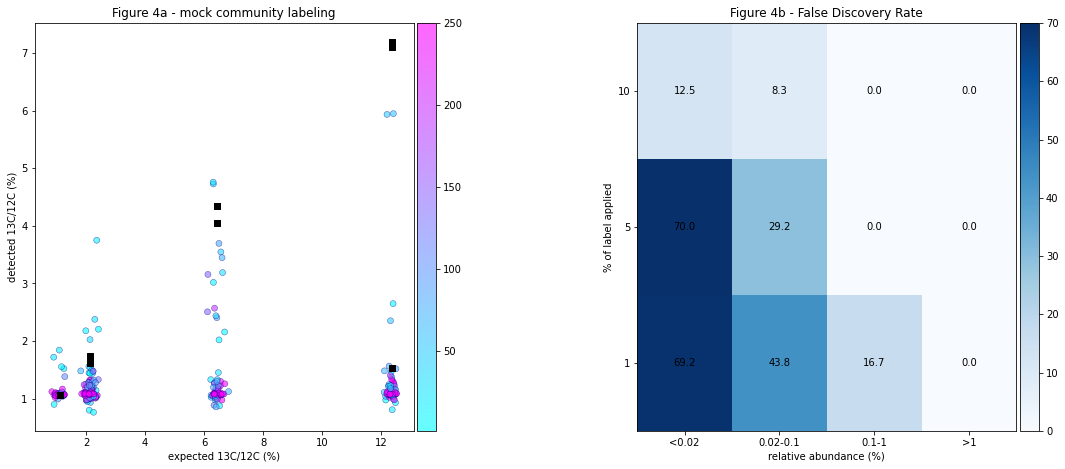

In [21]:
import random
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plot.figure(figsize=(18, 7.5))
fig.subplots_adjust(wspace=0.5)
fig.tight_layout()

ax1 = fig.add_subplot(121)
ax1.set_xlabel('expected 13C/12C (%)')
ax1.set_ylabel('detected 13C/12C (%)')
ax1.set_title("Figure 4a - mock community labeling")


# Figure 4a, simply plot raw data for positive labeling (E. coli) and negatives (all others).

# Figure 4a, negatives
benchmarks_minus_ecoli = benchmarks.loc[lambda df: df['bin'] != "K12", :]
benchmarks_minus_ecoli = benchmarks_minus_ecoli.loc[lambda df: df['bin'] != "CRAP", :]
benchmarks_minus_ecoli = benchmarks_minus_ecoli.dropna()

marker_colors = [min(250, n) for n in benchmarks_minus_ecoli["#spectra"].values]

# add some noise to x values to better see all the points 
x_values_0 = []
for x in benchmarks_minus_ecoli["ratio"].values:
    x_values_0.append(x + random.gauss(0, 0.125))

y_values_0 = benchmarks_minus_ecoli["NA median"].values
negatives = ax1.scatter(x_values_0, y_values_0, facecolors='none', edgecolors='navy', 
                        c=marker_colors, cmap = plot.get_cmap("cool"), alpha=0.6, 
                        linewidths=0.5) #edgecolors=b, 
# Figure 4a, e coli (black squares)
sub_benchmarks = benchmarks.loc[lambda df: df['bin'] == 'K12', :]
x_values_0 = sub_benchmarks["ratio"].values
y_values_0 = sub_benchmarks["NA median"].values
ax1.scatter(x_values_0, y_values_0, c='k', marker='s')
# Figure 4a color bar
# Figure 4a, note that the color is a measure for the # of spectra, the color map next to the image shows  
# # of spectra up to 250 (note that many populations have >250 spectra)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(negatives, cax=cax, orientation='vertical')

# Figure 4b - heatmap of false positive rate as function of relative abundance and label applied
#
# community structure was graphed as 4 categories
# relative abundance < 0.02 n = 4
# relative abundance  0.02 - 0.1 n =  8
# relative abundance  0.1 - 1 n =  6
# relative abundance  > 1 n =  6
# (also make sure "CRAP" is excluded)
#
# As a reasonable threshold, we take 1/4 of a generation, that means 10% of cells should be
# labeled compared to 50% for E. coli (1 generation).
# So the question is, for unlabeled populations in a given relative abundance category, how many measurements
# have higher "NA median" than the NA median that would correspond to 10% of cells labeled at a given amount of
# label applied?
#
# The heatmap shows that false positive rates are undetectable for populations more abundant than 1%
# To limit false discovery rates for rarer populations, application of a larger amou9nt of label (5 or 10%)
# is advantageous. Thus the amount of label applied is a tradeoff between quantification (see above) and 
# limiting false discovery rates

categories = [(0, 0.02), (0.02, 0.1), (0.1, 1), (1, 20)]
percent_label = [1, 5, 10]
thresholds = [1.07 + (1.7-1.07)/4,  1.07 + (4.2-1.07)/4, 1.07 + (7.1-1.07)/4]

x_labels = ['<0.02', '0.02-0.1', '0.1-1', '>1']
y_labels = ['10', '5', '1']

heatmap = np.zeros((3,4))

for i in range(4):
    c = categories[i]
    bin_selection = community_structure.loc[(lambda df: (df["relative abundance"] > c[0]) &
                                  (df["relative abundance"] <= c[1]) ), :]
    bins = frozenset(bin_selection["bin"].values)
    benchmarks_c = benchmarks_minus_ecoli.loc[lambda df: df["bin"].isin(bins), :]
    for j in range(3):
        l = percent_label[j]
        benchmarks_cl = benchmarks_c.loc[lambda df: df["% label"] == l, :]
        false_positives = len(benchmarks_cl.loc[lambda df: df["NA median"] > thresholds[j], :].index)
        total = len(benchmarks_cl.index)
        false_positive_rate = false_positives / total * 100
        heatmap[2-j][i] = false_positive_rate

ax2 = fig.add_subplot(122)
ax2.set_title("Figure 4b - False Discovery Rate")
heatmap_image = ax2.imshow(heatmap, cmap="Blues", aspect="auto")
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_xticklabels(labels=x_labels)
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_yticklabels(labels=y_labels)
#ax2.set_xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=90)
ax2.set_xlabel('relative abundance (%)')
ax2.set_ylabel('% of label applied')
for i in range(3):
    for j in range(4):
        text = ax2.text(j, i, f'{heatmap[i, j]:.1f}',
                       ha="center", va="center", color="k")


divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(heatmap_image, cax=cax, orientation='vertical');

In [22]:
# Figure 4c Estimating false negative rates:
# E coli was an abundant organisms in the mock community and its 13C/12C was therefore easy to estimate
# Would this estimation still work if E. coli was a rare organism?
# To address that question, we downsampled the E. coli spectra, to create collections of spectra that were
# similar (with regard to numbers) to collections of spectra actually sampled for rare populations. 
# We then plotted estimates for 13C/12C for those downsampled collections of labeled E. coli spectra...
# Note that we first remove the most intense spectra from the E. coli collection as the intensity of E. coli
# spectra is about 2x higher on average.
# To get an idea of the repropducibility, we perform 5 random downsamplings for each population.

categories = [(0, 0.02), (0.02, 0.1), (0.1, 1), (1, 20)]
percent_label = [1, 5, 10]
filenames = data["ms_run"].unique()
filename_label_hash = {}
for f in filenames:
    words = f.split('_')
    nominal_value = 0
    if len(words)>4:
        nominal_value = int(words[3])
    filename_label_hash[f] = nominal_value
data["% label"] = [filename_label_hash[f] for f in data["ms_run"].values]


# (we remove this outlier first:)
data_ecoli = data.loc[lambda df: df["ms_run"] != "Run1_MockU2_EcoliR1_10_2000ng", :]
data_ecoli = data_ecoli.loc[lambda df: df["bins"] == "K12", :]
data_ecoli = data_ecoli.loc[lambda df: df["spectrum_total_intensity"] < 9832732.821, :]

subsampled_ecoli_data = pd.DataFrame(columns=["% label", "abundance category", "bin", "ratio", "spectra", 
                                              "mean intensity", "NA median"])
background_13C = 0.011056585166521
background_12C = 1 - background_13C

for j in range(3):
    l = percent_label[j]
    subdata = data.loc[lambda df: df["% label"] == l, :]
    subdata_ecoli = data_ecoli.loc[lambda df: df["% label"] == l, :]
    unlabeled_fraction = 1 - l/100
    C12 = unlabeled_fraction * background_12C
    C13 = l/100 + unlabeled_fraction * background_13C
    ratio = C13/C12 * 100
    
    for i in range(4):
        c = categories[i]
        bin_selection = community_structure.loc[(lambda df: (df["relative abundance"] > c[0]) &
                                      (df["relative abundance"] <= c[1]) ), :]
        for b in bin_selection["bin"].values:
            if b == "CRAP":
                continue
            template_spectra_count = len(subdata.loc[lambda df: df["bins"] == b, :].index)
            for q in range(5):
                shuffled_indices = np.random.permutation(len(subdata_ecoli.index))
                selected_spectra = subdata_ecoli.iloc[shuffled_indices[:template_spectra_count]]
                subsampled_ecoli_data.loc[len(subsampled_ecoli_data)] = [l, i, b, ratio, 
                                                                len(selected_spectra.index),
                                                                selected_spectra['spectrum_total_intensity'].mean(),
                                                                selected_spectra['ratio_na'].median()]
subsampled_ecoli_data.style

,% label,abundance category,bin,ratio,spectra,mean intensity,NA median
0,1,0,Nm1,2.139,72,2665429.992,1.659
1,1,0,Nm1,2.139,72,2622937.850,1.558
2,1,0,Nm1,2.139,72,3411868.240,1.649
3,1,0,Nm1,2.139,72,3105234.222,1.720
4,1,0,Nm1,2.139,72,2801323.686,1.715
5,1,0,Ne1,2.139,71,2675182.147,1.670
6,1,0,Ne1,2.139,71,2969085.853,1.717
7,1,0,Ne1,2.139,71,3041225.278,1.727
8,1,0,Ne1,2.139,71,3028513.535,1.777
9,1,0,Ne1,2.139,71,2835120.500,1.688


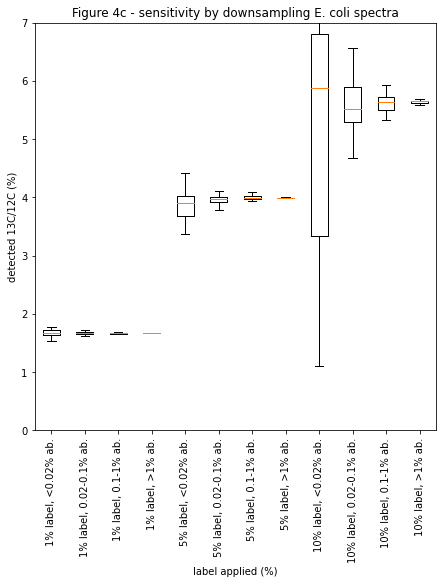

In [23]:
# Figure 4c shows that false negatives are undetectable, independent of the amount of label applied, even for very
# rare (<0.02% abundant) populations

fig = plot.figure(figsize=(18, 7.5))
fig.subplots_adjust(wspace=0.5)
fig.tight_layout()

category_labels = ['<0.02', '0.02-0.1', '0.1-1', '>1']

ax1 = fig.add_subplot(121)
ax1.set_xlabel('label applied (%)')
ax1.set_ylabel('detected 13C/12C (%)')
ax1.set_title("Figure 4c - sensitivity by downsampling E. coli spectra")

boxplots = []
labels = []
for j in range(3):
    subdata = subsampled_ecoli_data.loc[lambda df: df['% label'] == percent_label[j], :]
    for i in range(4):
        subdata2 = subdata.loc[lambda df: df['abundance category'] == i, :]
        boxplots.append(subdata2["NA median"].values)
        labels.append(f'{percent_label[j]}% label, {category_labels[i]}% ab.')

ax1.boxplot(boxplots, sym='')
ax1.set_ylim([0,7])
ax1.set_xticklabels(labels=labels,rotation=90);
                
